In [2]:
import osmnx as ox

In [3]:
G = ox.graph_from_point((51.474744, 5.679176), dist=200, network_type='drive', simplify=True, retain_all=False)

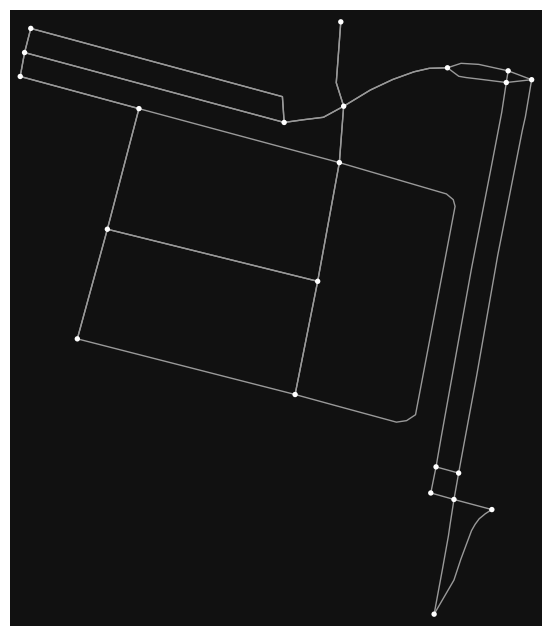

In [29]:
fig, ax = ox.plot_graph(G)

In [4]:
nodes, edges = ox.graph_to_gdfs(G)

In [ ]:
42726478
42726606
42726738
42726850

In [6]:
edges.head()

osmid    highway   lanes maxspeed  \
u        v          key                                                     
42726478 1399798114 0                 7142436    primary       2       70   
         42726738   0                 7143232  secondary       3       70   
42726606 42726478   0                 7143241    primary       3       70   
42726738 42726850   0                 7143229    primary       3       70   
         620734286  0    [7143178, 534233502]  secondary  [3, 2]       50   

                                          name  oneway   ref  reversed  \
u        v          key                                                  
42726478 1399798114 0              Deurneseweg    True  N270     False   
         42726738   0                      NaN    True   NaN     False   
42726606 42726478   0              Deurneseweg    True  N270     False   
42726738 42726850   0              Deurneseweg    True  N270     False   
         620734286  0    Wethouder van Wellaan    True   NaN     False   

                             length  \
u        v          key               
42726478 1399798114 0     16.902966   
         42726738   0     11.551216   
42726606 42726478   0     10.379466   
42726738 42726850   0     10.096853   
         620734286  0    172.492819   

                                                                  geometry  
u        v          key                                                     
42726478 1399798114 0      LINESTRING (5.67921 51.47469, 5.67945 51.47465)  
         42726738   0      LINESTRING (5.67921 51.47469, 5.67924 51.47479)  
42726606 42726478   0      LINESTRING (5.67907 51.47471, 5.67921 51.47469)  
42726738 42726850   0       LINESTRING (5.67924 51.47479, 5.6791 51.47481)  
         620734286  0    LINESTRING (5.67924 51.47479, 5.67927 51.47488...

In [7]:
edges['highway'].value_counts()

highway
residential     35
secondary        6
primary          3
primary_link     1
Name: count, dtype: int64

In [10]:
edges[edges['highway'] == 'primary']

,,,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,geometry
u,v,key,,,,,,,,,,
42726478,1399798114,0,7142436,primary,2,70,Deurneseweg,True,N270,False,16.902966,"LINESTRING (5.67921 51.47469, 5.67945 51.47465)"
42726606,42726478,0,7143241,primary,3,70,Deurneseweg,True,N270,False,10.379466,"LINESTRING (5.67907 51.47471, 5.67921 51.47469)"
42726738,42726850,0,7143229,primary,3,70,Deurneseweg,True,N270,False,10.096853,"LINESTRING (5.67924 51.47479, 5.6791 51.47481)"


In [ ]:
import networkx as nx 




def parse_speed(maxspeed, highway):
    """
    Turn maxspeed (which may be a list, str, number or None) into a float.
    If that fails, choose based on highway type (or list → 30, unknown → 50).
    """
    speed_defaults = {
        "primary":     80.0,
        "secondary":   70.0,
        "tertiary":    50.0,
        "residential": 30.0,
        "unclassified":30.0,
    }
    fall_back_speed = 50.0
    
    
    # if it's a list, take first element
    if isinstance(maxspeed, list):
        maxspeed = maxspeed[0]
    # try direct float conversion
    try:
        return float(maxspeed)
    except (TypeError, ValueError):
        # if highway is a list → always 30
        if isinstance(highway, list):
            return 30.0
        # else look up in our mapping
        return speed_defaults.get(highway, fall_back_speed)
    
def parse_length(length):
    """
    Turn length (which may be a list, str, number or None) into a float,
    defaulting to 30 m on failure.
    """
    fall_back_length = 30.0
    
    if isinstance(length, list):
        length = length[0]
    try:
        return float(length)
    except (TypeError, ValueError):
        return fall_back_length

def get_edge_features_subgraph(G_sub):
    """
    From subgraph G_sub, return an edges GeoDataFrame with:
      - maxspeed: float (km/h)
      - length:   float (m)
      - geometry: the edge geometries
    """
    # relabel nodes for consistency
    G0 = nx.convert_node_labels_to_integers(G_sub, ordering="sorted", first_label=0)
    # extract edges gdf
    _, edges = ox.graph_to_gdfs(G0)

    # apply parsers
    edges["maxspeed"] = edges.apply(
        lambda row: parse_speed(row.get("maxspeed"), row.get("highway")),
        axis=1,
    )
    edges["length"] = edges["length"].apply(parse_length)

    # ensure floats
    edges["maxspeed"] = edges["maxspeed"].astype(float)
    edges["length"]   = edges["length"].astype(float)

    return edges[["maxspeed", "length"]]

In [14]:
get_edge_features_subgraph(G)

maxspeed      length
u  v  key                      
0  19 0        70.0   16.902966
   2  0        70.0   11.551216
1  0  0        70.0   10.379466
2  3  0        70.0   10.096853
   17 0        50.0  172.492819
3  1  0        70.0   11.467683
4  5  0        30.0   96.904427
   6  0        30.0   49.764158
5  7  0        30.0   49.000445
6  7  0        30.0   93.403278
   8  0        30.0   52.017877
   4  0        30.0   49.764158
7  11 0        30.0   53.737315
   6  0        30.0   93.403278
   5  0        30.0   49.000445
8  10 0        30.0   24.378535
   6  0        30.0   52.017877
   4  0        30.0  200.691400
9  14 0        30.0  115.888136
   15 0        30.0  123.532586
   10 0        30.0   27.016733
10 8  0        30.0   24.378535
   16 0        30.0   36.935751
   9  0        30.0   27.016733
   20 0        50.0   48.460785
11 7  0        30.0   53.737315
   8  0        30.0   89.468027
   13 0        30.0   53.028601
12 21 0        50.0    5.101896
   20 0        50.0   26.794456
13 11 0        30.0   53.028601
   14 0        30.0   10.466321
14 9  0        30.0  115.888136
   15 0        30.0   10.756469
   13 0        30.0   10.466321
15 14 0        30.0   10.756469
   9  0        30.0  123.532586
16 10 0        30.0   36.935751
17 12 0        50.0   10.823733
18 0  0        50.0   50.189108
   19 0        50.0   52.485522
20 10 0        50.0   48.460785
   21 0        50.0   26.760625
21 17 0        50.0   11.002569
   3  0        50.0  168.457081

In [32]:
nodes.reset_index(inplace=True)

In [35]:
nodes

,osmid,y,x,street_count,geometry
0,42726478,51.474688,5.679213,4,POINT (5.67921 51.47469)
1,42726606,51.474714,5.679068,4,POINT (5.67907 51.47471)
2,42726738,51.474791,5.679242,4,POINT (5.67924 51.47479)
3,42726850,51.474815,5.679101,4,POINT (5.6791 51.47481)
4,42727547,51.475095,5.678224,3,POINT (5.67822 51.4751)
5,42728165,51.475311,5.676868,3,POINT (5.67687 51.47531)
6,42728835,51.475534,5.678364,3,POINT (5.67836 51.47553)
7,42729560,51.475736,5.677055,3,POINT (5.67706 51.47574)
8,42730332,51.475994,5.678499,4,POINT (5.6785 51.47599)
9,42730799,51.476150,5.678156,3,POINT (5.67816 51.47615)


In [16]:
import pandas as pd

In [17]:
time_series = pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed/node_features.parquet")

In [24]:
time_series[time_series['node_id'].isin(nodes.index)].drop_duplicates(subset=['node_id'])

,node_id,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
116256,42726478,HEL106,51.474688,5.679213,1,7.342997,2024-01-31,44.87
116448,42726606,HEL106,51.474714,5.679068,1,10.290686,2024-01-31,44.87
116928,42726738,HEL106,51.474791,5.679242,1,4.911506,2024-01-31,44.87
117024,42726850,HEL106,51.474815,5.679101,1,9.707794,2024-01-31,44.87
300672,1399798110,0,51.474244,5.679089,0,57.290021,2024-01-31,0.00
300768,1399798114,HEL106,51.474649,5.679449,1,20.676580,2024-01-31,44.87


In [6]:
G = ox.graph_from_bbox((5.67676, 51.47096, 5.70173, 51.47922), simplify=True, network_type='drive', retain_all=False)

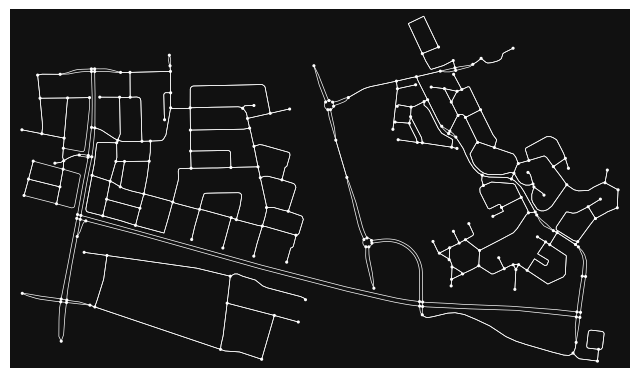

In [7]:
ax, fig = ox.plot_graph(G, node_size=5, edge_color='white', edge_linewidth=0.5, show=False)

In [31]:
nodes, edges = ox.graph_to_gdfs(G)
nodes.reset_index('osmid', inplace=True)

In [34]:
nodes

,osmid,y,x,street_count,geometry
0,42715874,51.471050,5.686790,3,POINT (5.68679 51.47105)
1,42716199,51.471210,5.699793,3,POINT (5.69979 51.47121)
2,42716554,51.471307,5.685072,4,POINT (5.68507 51.47131)
3,42717008,51.471520,5.678420,3,POINT (5.67842 51.47152)
4,42718215,51.472020,5.688320,1,POINT (5.68832 51.47202)
...,...,...,...,...,...
227,8194364285,51.478959,5.682935,2,POINT (5.68294 51.47896)
228,8194364286,51.478683,5.682964,2,POINT (5.68296 51.47868)
229,10101382565,51.473945,5.685170,1,POINT (5.68517 51.47394)
230,10101382566,51.474165,5.683867,1,POINT (5.68387 51.47416)


In [32]:
nodes[nodes['osmid']==42733391]

,osmid,y,x,street_count,geometry
126,42733391,51.477068,5.679823,4,POINT (5.67982 51.47707)


In [33]:
nodes[nodes['osmid'] == 42724442]

,osmid,y,x,street_count,geometry
38,42724442,51.474035,5.699894,3,POINT (5.69989 51.47403)


In [23]:
import networkx as nx

In [9]:
import pandas as pd 

expanded = pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed/node_features_expanded.parquet")
nan_avg = pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed/node_features_filled_nan_average.parquet")

In [10]:
expanded.head()

,node_id,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:00:00,26.932969
1,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:01:00,25.983766
2,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:02:00,26.238372
3,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:03:00,26.230594
4,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:04:00,26.309491


In [3]:
nan_avg.head()

,node_id,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:00:00,26.932969
1,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:15:00,29.121562
2,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:30:00,26.209375
3,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:45:00,21.016875
4,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 01:00:00,23.342500


In [4]:
import pandas as pd
import numpy as np


def expand_wait_times(df, num_peaks=2, amp_frac=0.1, sigma=1.0):
    """
    Expand a DataFrame of 15-minute averaged wait_times into per-minute resolution
    with small Gaussian bumps for realistic variation.

    Parameters:
    ----------
    df : pd.DataFrame
        Input DataFrame with columns ['node_id', 'timestamp', 'wait_time'] where
        'timestamp' is a Timestamp at 15-minute intervals.
    num_peaks : int, default=2
        Number of random Gaussian bumps to add per 15-minute block.
    amp_frac : float, default=0.1
        Maximum bump height as a fraction of the block's start wait_time.
    sigma : float, default=1.0
        Width (in minutes) of each Gaussian bump.

    Returns:
    -------
    pd.DataFrame
        Expanded DataFrame at 1-minute resolution with columns
        ['node_id', 'timestamp', 'wait_time'].
    """
    # Make a working copy and extract date
    df2 = df.copy()
    df2["timestamp"] = pd.to_datetime(df2["timestamp"])
    df2["date"] = df2["timestamp"].dt.date

    def expand_block(avg_k, avg_k1):
        t = np.arange(15)
        # 1) linear baseline
        baseline = avg_k + (avg_k1 - avg_k) * (t / 15.0)

        # 2) add Gaussian bumps
        peaks = np.zeros_like(t, dtype=float)
        for _ in range(num_peaks):
            center = np.random.uniform(0, 15)
            height = np.random.uniform(0, amp_frac * avg_k)
            peaks += height * np.exp(-0.5 * ((t - center) / sigma) ** 2)
        peaks[0] = 0.0  # ensure the first minute stays exact

        # 3) combine
        y_raw = baseline + peaks

        # 4) correct only the in-between minutes so their mean matches avg_k
        delta = y_raw[1:].mean() - avg_k
        y = y_raw.copy()
        y[1:] = y_raw[1:] - delta

        # 5) clip negatives
        return np.clip(y, 0, None)

    rows = []

    # Group by node and day to avoid crossing midnight
    for (node, day), group in df2.groupby(["node_id", "date"]):
        group = group.sort_values("timestamp").reset_index(drop=True)
        for i, row in group.iterrows():
            avg_k = row["wait_time"]
            avg_k1 = group.loc[i + 1, "wait_time"] if i < len(group) - 1 else avg_k
            start_ts = row["timestamp"]
            y = expand_block(avg_k, avg_k1)

            # build 15 per-minute rows
            for offset, wt in enumerate(y):
                row_data = row.drop("date").to_dict()
                row_data["timestamp"] = start_ts + pd.Timedelta(minutes=offset)
                row_data["wait_time"] = wt
                rows.append(row_data)
                # rows.append(
                #     {
                #         "node_id": node,
                #         "timestamp": start_ts + pd.Timedelta(minutes=offset),
                #         "wait_time": wt,
                #     }
                # )

    # Assemble final DataFrame
    new_df = pd.DataFrame(rows)
    new_df = new_df.sort_values(["node_id", "timestamp"]).reset_index(drop=True)

    return new_df

In [6]:
nan_avg_small = nan_avg[:100]

In [7]:
new_df = expand_wait_times(
        nan_avg_small, num_peaks=3, amp_frac=0.1, sigma=1.5
    )

In [8]:
new_df.head()

,node_id,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:00:00,26.932969
1,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:01:00,27.209364
2,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:02:00,27.509335
3,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:03:00,27.511212
4,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:04:00,27.293151


In [15]:
import osmnx as ox
import geopandas as gpd

In [164]:
nodes_hel = pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed_new/helmond_nodes.parquet")

In [165]:
nodes_hel.head()

,osmid,lat,lon,street_count,highway,geometry
0,34399134,51.486591,5.605116,3,None,b'\x01\x01\x00\x00\x00\xe8+\xedy\xa3k\x16@jDz\...
1,34399138,51.488014,5.607059,1,None,b'\x01\x01\x00\x00\x00=\xee\x00\xf4\xa0m\x16@\...
2,34399144,51.489518,5.609281,1,None,b'\x01\x01\x00\x00\x006;R}\xe7o\x16@\xaa\xe7\x...
3,34399155,51.505733,5.599784,3,None,b'\x01\x01\x00\x00\x00\x9b\x9a\xba\xe1-f\x16@\...
4,42635988,51.442332,5.718059,3,None,b'\x01\x01\x00\x00\x00!^2\xe9J\xdf\x16@\xcd>\x...


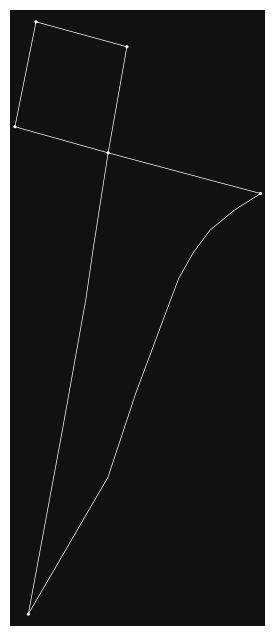

In [151]:
G = ox.graph_from_point((51.474744, 5.679176), dist=100, network_type='drive', simplify=True, retain_all=False)
fig, ax = ox.plot_graph(G, node_size=5, edge_color='white', edge_linewidth=0.5, show=False)
G_proj = ox.project_graph(G)


In [152]:
nodes, edges = ox.graph_to_gdfs(G_proj)
edges

osmid       highway lanes maxspeed  \
u          v          key                                           
42726478   1399798114 0      7142436       primary     2       70   
           42726738   0      7143232     secondary     3       70   
42726738   42726850   0      7143229       primary     3       70   
42726606   42726478   0      7143241       primary     3       70   
42726850   42726606   0      7143227     secondary     3       70   
1399798110 42726478   0      7143219     secondary     3       50   
           1399798114 0    126221505  primary_link     1       50   

                                  name  oneway   ref  reversed     length  \
u          v          key                                                   
42726478   1399798114 0    Deurneseweg    True  N270     False  16.902966   
           42726738   0            NaN    True   NaN     False  11.551216   
42726738   42726850   0    Deurneseweg    True  N270     False  10.096853   
42726606   42726478   0    Deurneseweg    True  N270     False  10.379466   
42726850   42726606   0            NaN    True   NaN     False  11.467683   
1399798110 42726478   0      Lage Dijk    True   NaN     False  50.189108   
           1399798114 0      Lage Dijk    True   NaN     False  52.485522   

                                                                    geometry  
u          v          key                                                     
42726478   1399798114 0    LINESTRING (686059.343 5706018.561, 686075.875...  
           42726738   0    LINESTRING (686059.343 5706018.561, 686060.94 ...  
42726738   42726850   0    LINESTRING (686060.94 5706030.009, 686051.08 5...  
42726606   42726478   0    LINESTRING (686049.221 5706020.996, 686059.343...  
42726850   42726606   0    LINESTRING (686051.08 5706032.32, 686049.221 5...  
1399798110 42726478   0    LINESTRING (686052.571 5705968.802, 686055.493...  
           1399798114 0    LINESTRING (686052.571 5705968.802, 686060.602...

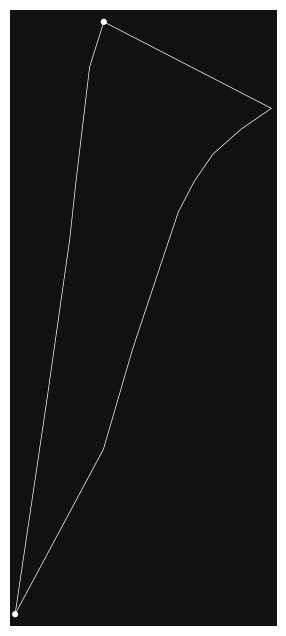

In [162]:
g_cons = ox.simplification.consolidate_intersections(
    G_proj, tolerance=10, rebuild_graph=True, dead_ends=False, reconnect_edges=True
)
fig, ax = ox.plot_graph(g_cons, node_size=20, edge_color='white', edge_linewidth=0.5, show=False)

In [154]:
nodes, edges = ox.graph_to_gdfs(g_cons)

In [155]:
edges

osmid       highway lanes maxspeed       name  oneway  reversed  \
u v key                                                                        
1 0 0      7143219     secondary     3       50  Lage Dijk    True     False   
    1    126221505  primary_link     1       50  Lage Dijk    True     False   

            length                                           geometry  \
u v key                                                                 
1 0 0    54.526191  LINESTRING (686052.571 5705968.802, 686055.493...   
    1    69.701096  LINESTRING (686052.571 5705968.802, 686060.602...   

         u_original  v_original  
u v key                          
1 0 0    1399798110    42726478  
    1    1399798110  1399798114

In [157]:
nodes

,osmid_original,x,y,cluster,street_count,geometry
osmid,,,,,,
0,"[42726478, 1399798114, 42726738, 42726606, 427...",686060.634306,5.706023e+06,0.0,2,POINT (686060.634 5706022.667)
1,1399798110,686052.571219,5.705969e+06,NaN,3,POINT (686052.571 5705968.802)


In [158]:
G_unproj = ox.project_graph(g_cons, to_crs='EPSG:4326')

In [159]:
nodes, edges = ox.graph_to_gdfs(G_unproj)

In [160]:
nodes

,osmid_original,x,y,street_count,cluster,geometry
osmid,,,,,,
1,1399798110,5.679089,51.474244,3,NaN,POINT (5.67909 51.47424)
0,"[42726478, 1399798114, 42726738, 42726606, 427...",5.679233,51.474725,2,0.0,POINT (5.67923 51.47472)


In [161]:
edges

osmid       highway lanes maxspeed       name  oneway  reversed  \
u v key                                                                        
1 0 0      7143219     secondary     3       50  Lage Dijk    True     False   
    1    126221505  primary_link     1       50  Lage Dijk    True     False   

            length                                           geometry  \
u v key                                                                 
1 0 0    54.526191  LINESTRING (5.67909 51.47424, 5.67914 51.47442...   
    1    69.701096  LINESTRING (5.67909 51.47424, 5.67921 51.47438...   

         u_original  v_original  
u v key                          
1 0 0    1399798110    42726478  
    1    1399798110  1399798114

In [114]:
G_proj = ox.project_graph(G)
nodes, edges = ox.graph_to_gdfs(G_proj)
coords = np.array(list(zip(nodes.geometry.x, nodes.geometry.y)))
print(coords)

[[ 686059.34324543 5706018.56090001]
 [ 686075.87540555 5706014.80184129]
 [ 686060.94042519 5706030.00890943]
 [ 686049.22132012 5706020.99598476]
 [ 686051.0803113  5706032.31997255]
 [ 686086.28915405 5706200.73358163]
 [ 685989.02409742 5706061.28907989]
 [ 685894.02226334 5706081.83924258]
 [ 685996.99354649 5706110.44549556]
 [ 685905.27771924 5706129.56811232]
 [ 686004.48729701 5706161.95595449]
 [ 685917.02659862 5706182.0467922 ]
 [ 686005.46543356 5706186.32950599]
 [ 685980.00379569 5706178.39470471]
 [ 685866.71395714 5706204.41054304]
 [ 685869.01298138 5706214.92666703]
 [ 686002.89841979 5706222.65311185]
 [ 686049.71193117 5706204.53803004]
 [ 685865.20891335 5706194.04592727]
 [ 686075.99819193 5706204.18668319]
 [ 686075.37025955 5706199.12022814]
 [ 686052.57121894 5705968.80246209]]


In [115]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import numpy as np

In [116]:
clustering = DBSCAN(eps=20, min_samples=1).fit(coords)
nodes["cluster"] = clustering.labels_
print(nodes)

                       y              x  street_count  \
osmid                                                   
42726478    5.706019e+06  686059.343245             4   
1399798114  5.706015e+06  686075.875406             3   
42726738    5.706030e+06  686060.940425             4   
42726606    5.706021e+06  686049.221320             4   
42726850    5.706032e+06  686051.080311             4   
620734286   5.706201e+06  686086.289154             4   
42727547    5.706061e+06  685989.024097             3   
42728165    5.706082e+06  685894.022263             3   
42728835    5.706110e+06  685996.993546             3   
42729560    5.706130e+06  685905.277719             3   
42730332    5.706162e+06  686004.487297             4   
42730965    5.706182e+06  685917.026599             3   
42730952    5.706186e+06  686005.465434             4   
42730799    5.706178e+06  685980.003796             3   
42731528    5.706204e+06  685866.713957             4   
42731792    5.706215e+06  68586

In [117]:
edges

osmid       highway  \
u          v          key                                                  
42726478   1399798114 0                            7142436       primary   
           42726738   0                            7143232     secondary   
42726738   42726850   0                            7143229       primary   
           620734286  0               [7143178, 534233502]     secondary   
42726606   42726478   0                            7143241       primary   
42726850   42726606   0                            7143227     secondary   
620734286  42731199   0                            7142820   residential   
42727547   42728165   0                            7142633   residential   
           42728835   0                            7143066   residential   
42728165   42729560   0                            7142849   residential   
42728835   42729560   0                            7142916   residential   
           42730332   0                            7143066   residential   
           42727547   0                            7143066   residential   
42729560   42730965   0                            7142849   residential   
           42728835   0                            7142916   residential   
           42728165   0                            7142849   residential   
42730332   42730952   0                            7143066   residential   
           42728835   0                            7143066   residential   
           42727547   0        [7142929, 7142635, 7142989]   residential   
42730965   42729560   0                            7142849   residential   
           42730332   0                            7142888   residential   
           42731261   0                            7143011   residential   
42730952   42730332   0                            7143066   residential   
           42731831   0                            7142870   residential   
           42730799   0                            7143006   residential   
           4485757329 0                          534233966   residential   
42730799   42731528   0                            7143006   residential   
           42731792   0                            7142866   residential   
           42730952   0                            7143006   residential   
42731528   42730799   0                            7143006   residential   
           42731792   0                            7143022   residential   
           42731261   0                            7143022   residential   
42731792   42731528   0                            7143022   residential   
           42730799   0                            7142866   residential   
42731831   42730952   0                            7142870   residential   
4485757329 42730952   0                          534233966   residential   
           5181551477 0                          534233967   residential   
42731261   42730965   0                            7143011   residential   
           42731528   0                            7143022   residential   
42731199   5181551477 0                            7143224     secondary   
           4485757329 0                            7142920   residential   
5181551477 620734286  0                          534233967   residential   
           42726850   0    [7143224, 534233968, 534233501]     secondary   
1399798110 42726478   0                            7143219     secondary   
           1399798114 0                          126221505  primary_link   

                               lanes maxspeed  \
u          v          key                       
42726478   1399798114 0            2       70   
           42726738   0            3       70   
42726738   42726850   0            3       70   
           620734286  0       [3, 2]       50   
42726606   42726478   0            3       70   
42726850   42726606   0            3       70   
620734286  42731199   0          NaN       50   
42727547   42728165   0          NaN   

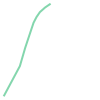

In [128]:
edges['geometry'].iloc[-1]

In [104]:
G_new = nx.MultiDiGraph()
cluster_to_node = {}
cluster_geoms = {}

for cluster_id in nodes["cluster"].unique():
    members = nodes[nodes["cluster"] == cluster_id]
    centroid = members.unary_union.centroid
    node_id = f"cluster_{cluster_id}"
    cluster_to_node[cluster_id] = node_id
    cluster_geoms[node_id] = centroid
    G_new.add_node(node_id, x=centroid.x, y=centroid.y)

for u, v, data in G_proj.edges(data=True):
    cluster_u = cluster_to_node[nodes.loc[u, "cluster"]]
    cluster_v = cluster_to_node[nodes.loc[v, "cluster"]]
    if cluster_u != cluster_v:
        G_new.add_edge(cluster_u, cluster_v, **data)



/tmp/ipykernel_27073/1644747962.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = members.unary_union.centroid
/tmp/ipykernel_27073/1644747962.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = members.unary_union.centroid
/tmp/ipykernel_27073/1644747962.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = members.unary_union.centroid
/tmp/ipykernel_27073/1644747962.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = members.unary_union.centroid
/tmp/ipykernel_27073/1644747962.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = members.unary_union.centroid
/tmp/ipykernel_27073/1644747962.py:7: DeprecationWarning: The 'unary_union' attribute is deprec

In [105]:
for n, data in G_new.nodes(data=True):
    print(f"Node {n}: {data}")

Node cluster_0: {'x': 686059.2921415198, 'y': 5706023.33752161}
Node cluster_1: {'x': 686079.2192018452, 'y': 5706201.346830983}
Node cluster_2: {'x': 685989.0240974176, 'y': 5706061.289079889}
Node cluster_3: {'x': 685894.022263345, 'y': 5706081.839242578}
Node cluster_4: {'x': 685996.9935464871, 'y': 5706110.44549556}
Node cluster_5: {'x': 685905.2777192402, 'y': 5706129.56811232}
Node cluster_6: {'x': 686004.4872970142, 'y': 5706161.955954486}
Node cluster_7: {'x': 685917.0265986222, 'y': 5706182.046792197}
Node cluster_8: {'x': 686005.4654335568, 'y': 5706186.329505994}
Node cluster_9: {'x': 685980.0037956875, 'y': 5706178.394704712}
Node cluster_10: {'x': 685866.9786172926, 'y': 5706204.461045782}
Node cluster_11: {'x': 686002.8984197932, 'y': 5706222.653111848}
Node cluster_12: {'x': 686049.7119311693, 'y': 5706204.538030043}
Node cluster_13: {'x': 686052.5712189361, 'y': 5705968.802462091}


In [106]:
G_new.graph['crs'] = G_proj.graph['crs']

In [107]:
from shapely.geometry import LineString

for u, v, k, data in G_new.edges(keys=True, data=True):
    # Get node coordinates
    x1, y1 = G_new.nodes[u]['x'], G_new.nodes[u]['y']
    x2, y2 = G_new.nodes[v]['x'], G_new.nodes[v]['y']
    
    # Replace or add geometry
    data['geometry'] = LineString([(x1, y1), (x2, y2)])

In [108]:

G_unproj = ox.project_graph(G_new, to_crs='EPSG:4326')

In [109]:
nodes, edges = ox.graph_to_gdfs(G_unproj)
print(nodes)

                   x          y                  geometry
osmid                                                    
cluster_0   5.679214  51.474731  POINT (5.67921 51.47473)
cluster_1   5.679595  51.476324  POINT (5.67959 51.47632)
cluster_12  5.679172  51.476362  POINT (5.67917 51.47636)
cluster_2   5.678224  51.475095   POINT (5.67822 51.4751)
cluster_3   5.676868  51.475311  POINT (5.67687 51.47531)
cluster_4   5.678364  51.475534  POINT (5.67836 51.47553)
cluster_5   5.677055  51.475736  POINT (5.67706 51.47574)
cluster_6   5.678499  51.475994   POINT (5.6785 51.47599)
cluster_7   5.677252  51.476203   POINT (5.67725 51.4762)
cluster_8   5.678526  51.476213  POINT (5.67853 51.47621)
cluster_10  5.676544  51.476421  POINT (5.67654 51.47642)
cluster_11  5.678508  51.476540  POINT (5.67851 51.47654)
cluster_9   5.678156  51.476150  POINT (5.67816 51.47615)
cluster_13  5.679089  51.474244  POINT (5.67909 51.47424)


In [110]:
edges

osmid       highway  \
u          v          key                                                  
cluster_0  cluster_1  0               [7143178, 534233502]     secondary   
cluster_1  cluster_12 0                            7142920   residential   
           cluster_0  0    [7143224, 534233968, 534233501]     secondary   
cluster_12 cluster_8  0                          534233966   residential   
           cluster_1  0                          534233967   residential   
cluster_2  cluster_3  0                            7142633   residential   
           cluster_4  0                            7143066   residential   
cluster_3  cluster_5  0                            7142849   residential   
cluster_4  cluster_5  0                            7142916   residential   
           cluster_6  0                            7143066   residential   
           cluster_2  0                            7143066   residential   
cluster_5  cluster_7  0                            7142849   residential   
           cluster_4  0                            7142916   residential   
           cluster_3  0                            7142849   residential   
cluster_6  cluster_8  0                            7143066   residential   
           cluster_4  0                            7143066   residential   
           cluster_2  0        [7142929, 7142635, 7142989]   residential   
cluster_7  cluster_5  0                            7142849   residential   
           cluster_6  0                            7142888   residential   
           cluster_10 0                            7143011   residential   
cluster_8  cluster_6  0                            7143066   residential   
           cluster_11 0                            7142870   residential   
           cluster_9  0                            7143006   residential   
           cluster_12 0                          534233966   residential   
cluster_10 cluster_9  0                            7143006   residential   
                      1                            7142866   residential   
           cluster_7  0                            7143011   residential   
cluster_11 cluster_8  0                            7142870   residential   
cluster_9  cluster_10 0                            7143006   residential   
                      1                            7142866   residential   
           cluster_8  0                            7143006   residential   
cluster_13 cluster_0  0                            7143219     secondary   
                      1                          126221505  primary_link   

                               lanes maxspeed  \
u          v          key                       
cluster_0  cluster_1  0       [3, 2]       50   
cluster_1  cluster_12 0          NaN       50   
           cluster_0  0    [4, 3, 2]       50   
cluster_12 cluster_8  0          NaN       50   
           cluster_1  0          NaN       50   
cluster_2  cluster_3  0          NaN       30   
           cluster_4  0          NaN       30   
cluster_3  cluster_5  0          NaN       30   
cluster_4  cluster_5  0          NaN       30   
           cluster_6  0          NaN       30   
           cluster_2  0          NaN       30   
cluster_5  cluster_7  0          NaN       30   
           cluster_4  0          NaN       30   
           cluster_3  0          NaN       30   
cluster_6  cluster_8  0          NaN       30   
           cluster_4  0          NaN       30   
           cluster_2  0          NaN       30   
cluster_7  cluster_5  0          NaN       30   
           cluster_6  0          NaN       30   
           cluster_10 0          NaN       30   
cluster_8  cluster_6  0          NaN       30   
           cluster_11 0          NaN       30   
           cluster_9  0          NaN       30   
           cluster_12 0          NaN       50   
cluster_10 cluster_9  0          NaN       30   
                      1          NaN       30   
           cluster_7

ValueError: aspect must be finite and positive 

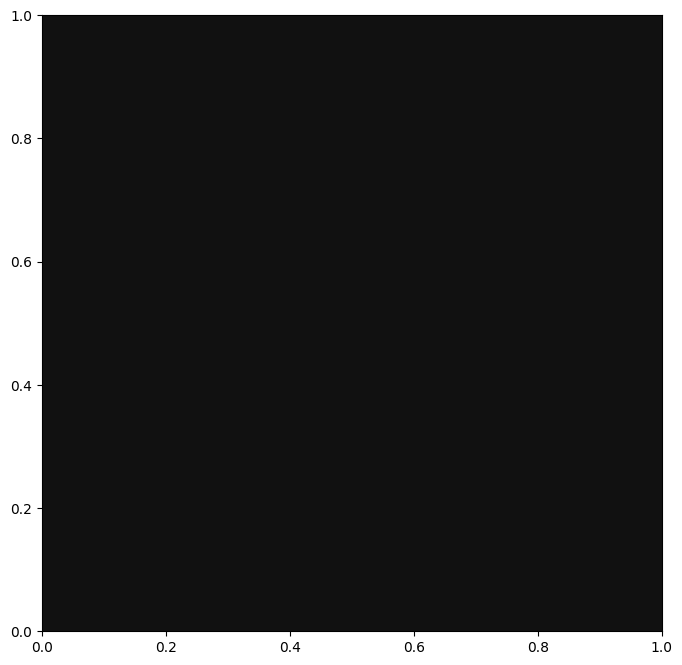

In [111]:
fig, ax = ox.plot_graph(G_unproj, node_size=5, edge_color='white', edge_linewidth=0.5, show=False) 

In [166]:
lijst = [1,2,3,4,5]

var = ", ".join(str(x) for x in lijst)
print(var)

1, 2, 3, 4, 5


In [169]:
pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed_new/subgraph_nodes.parquet")

,node_id,lat,lon,osmid_original
0,0,51.474725,5.679233,"[42726478, 1399798114, 42726738, 42726606, 427..."
1,1,51.474244,5.679089,[1399798110]


In [170]:
G = ox.graph_from_point((51.474744, 5.679176), dist=200, network_type='drive', simplify=True, retain_all=False)

In [171]:
nodes, edges = ox.graph_to_gdfs(G)

In [175]:
pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed_new/timeseries_subgraph.parquet")

,node_id,osmid_original,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,0,"[42726478, 1399798114, 42726738, 42726606, 427...",HEL106,51.474725,5.679233,1,3.913514,2024-01-31 00:00:00,44.87
1,0,"[42726478, 1399798114, 42726738, 42726606, 427...",HEL106,51.474725,5.679233,1,3.913514,2024-01-31 00:15:00,33.74
2,0,"[42726478, 1399798114, 42726738, 42726606, 427...",HEL106,51.474725,5.679233,1,3.913514,2024-01-31 00:30:00,51.15
3,0,"[42726478, 1399798114, 42726738, 42726606, 427...",HEL106,51.474725,5.679233,1,3.913514,2024-01-31 00:45:00,25.61
4,0,"[42726478, 1399798114, 42726738, 42726606, 427...",HEL106,51.474725,5.679233,1,3.913514,2024-01-31 01:00:00,23.14
...,...,...,...,...,...,...,...,...,...
187,1,[1399798110],0,51.474244,5.679089,0,57.290021,2024-01-31 22:45:00,74.08
188,1,[1399798110],0,51.474244,5.679089,0,57.290021,2024-01-31 23:00:00,67.57
189,1,[1399798110],0,51.474244,5.679089,0,57.290021,2024-01-31 23:15:00,78.97
190,1,[1399798110],0,51.474244,5.679089,0,57.290021,2024-01-31 23:30:00,45.62


In [178]:
pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/training_data/subgraph_2/timeseries.parquet")

,node_id,osmid_original,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,0,[42809617],0,51.499158,5.669493,0,763.61515,2024-01-31 00:00:00,0.0
1,0,[42809617],0,51.499158,5.669493,0,763.61515,2024-01-31 00:15:00,0.0
2,0,[42809617],0,51.499158,5.669493,0,763.61515,2024-01-31 00:30:00,0.0
3,0,[42809617],0,51.499158,5.669493,0,763.61515,2024-01-31 00:45:00,0.0
4,0,[42809617],0,51.499158,5.669493,0,763.61515,2024-01-31 01:00:00,0.0
...,...,...,...,...,...,...,...,...,...
187,1,[42813311],0,51.499977,5.669050,0,830.68827,2024-01-31 22:45:00,0.0
188,1,[42813311],0,51.499977,5.669050,0,830.68827,2024-01-31 23:00:00,0.0
189,1,[42813311],0,51.499977,5.669050,0,830.68827,2024-01-31 23:15:00,0.0
190,1,[42813311],0,51.499977,5.669050,0,830.68827,2024-01-31 23:30:00,0.0


In [180]:
pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/training_data/subgraph_0/timeseries.parquet")

,node_id,osmid_original,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,0,[42734230],0,51.477360,5.693010,0,525.541040,2024-01-31 00:00:00,0.0
1,0,[42734230],0,51.477360,5.693010,0,525.541040,2024-01-31 00:01:00,0.0
2,0,[42734230],0,51.477360,5.693010,0,525.541040,2024-01-31 00:02:00,0.0
3,0,[42734230],0,51.477360,5.693010,0,525.541040,2024-01-31 00:03:00,0.0
4,0,[42734230],0,51.477360,5.693010,0,525.541040,2024-01-31 00:04:00,0.0
...,...,...,...,...,...,...,...,...,...
11515,7,[42738532],0,51.478721,5.695608,0,681.346242,2024-01-31 23:55:00,0.0
11516,7,[42738532],0,51.478721,5.695608,0,681.346242,2024-01-31 23:56:00,0.0
11517,7,[42738532],0,51.478721,5.695608,0,681.346242,2024-01-31 23:57:00,0.0
11518,7,[42738532],0,51.478721,5.695608,0,681.346242,2024-01-31 23:58:00,0.0
